# SLT-CE-5: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [1]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D

# Fix randoom seed for reproducibility
np.random.seed(42)

from sklearn.utils.linear_assignment_ import linear_assignment
import numpy.lib.index_tricks as ndi
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from importlib import reload

In [2]:
%matplotlib inline
tsne_rs = 48

The number of nodes is hardcoded for simplicity (taken from [2]):

In [3]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [4]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [5]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
        self.n = None
        self.d_mat = None
        
    def centralize(self, M):
        '''
        Returns the centralized version of the given matrix.
        '''
        assert(M.shape[0] == M.shape[1])
        n = M.shape[0]
        q = np.eye(n) - np.ones(M.shape) / n
        return np.matmul(np.matmul(q, M), q)
    
    def preprocess_PMAT(self, PMAT):
        '''
        Construct self-edges for each node and asserts the edges are symmetric.
        '''
        for i in range(self.n):
            PMAT[i,i] = 1
        assert(np.where(PMAT != PMAT.T)[0].size == 0)
        return PMAT
    
    def dists_pairwiseXOR(self, PMAT):
        '''
        Defines the pairwise distance for two nodes 
        as the sum of their XORed neighborhoods.
        '''
        # Convert into boolean matrix
        PMAT = PMAT == True
        d_mat = np.zeros(PMAT.shape)
        for i in range(self.n):
            for j in range(self.n):
                d_mat[i,j] = np.sum(np.logical_xor(PMAT[i], PMAT[j]).astype(int))
        # d_mat = np.load('pairwiseXOR.npy')
        assert np.allclose(d_mat, d_mat.T)
        return d_mat
    
    def dists_1mIoU(self, PMAT):
        '''
        Defines the pairwise distance for two nodes as the
        1 minus "intersection over union" of their common edges.
        '''
        # Convert into boolean matrix
        PMAT = PMAT == True
        d_mat = np.zeros(PMAT.shape)
        for i in range(self.n):
            for j in range(self.n):
                and_ij = np.logical_and(PMAT[i], PMAT[j])
                or_ij = np.logical_or(PMAT[i], PMAT[j])
                inter_ = np.sum(and_ij.astype(float))
                union_ = np.sum(or_ij.astype(float))
                d_mat[i,j] = 1 - (inter_ / union_)
        # d_mat = np.load('1mIoU.npy')
        assert np.allclose(d_mat, d_mat.T)
        return d_mat

    def dists_FloydWarshall(self, PMAT, infty='max', maxw=2):
        '''
        Defines the pairwise distance for two nodes 
        as the distance between them, 
        substituting infinite distances with a given value.
        '''
        # Floyd-Warshall algorithm
        d_mat = np.ones(PMAT.shape) # All edge weights are one
        d_mat[np.where(PMAT == 0)] = np.inf # Infinite distance if not adjacent
        for i in range(self.n):
            d_mat[i,i] = 0  # Diagonal is zero
        for k in range(self.n):
            print(k)
            for i in range(self.n):
                for j in range(self.n):
                    if d_mat[i,j] > d_mat[i,k] + d_mat[k,j]:
                        d_mat[i,j] = d_mat[i,k] + d_mat[k,j]
        # d_mat = np.load('floydwarshall.npy')
        
        infidxs = d_mat == np.inf
        # print(np.where(infidxs[0] == True)) # non-connected nodes
        if infty == 'max':
            d_mat[infidxs] = 0
            d_mat[infidxs] = maxw * np.max(d_mat)
        else:
            d_mat[infidxs] = infty
        assert np.allclose(d_mat, d_mat.T)
        return d_mat
    
    def dists_pwAbsSum(self, PMAT):
        '''
        Defines the pairwise distance for two nodes 
        as the sum of the absolute distances of them
        w.r.t. another dissimilarity metric.
        '''
        fw_mat = self.dists_1mIoU(PMAT)
        d_mat = np.zeros(fw_mat.shape)
        for i in range(self.n):
            for j in range(self.n):
                d_mat[i,j] = np.sum(np.abs(fw_mat[i] - fw_mat[j]))
        # d_mat = np.load('pwAbsSum.npy')
        assert np.allclose(d_mat, d_mat.T)
        return d_mat
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        n = PMAT.shape[0]
        self.n = n
        
        PMAT = self.preprocess_PMAT(PMAT)
        d_mat = self.dists_1mIoU(PMAT).astype(float)
        d_mat = (d_mat + d_mat.T) / 2.0
        self.d_mat = d_mat
        
        d_cent = self.centralize(d_mat) # D^c
        s_cent = - 0.5 * d_cent # S^c
        w, v = np.linalg.eigh(s_cent)
        s_tilde = s_cent - np.diag(np.min(w) * np.ones(n)) # S~
        
        d_tilde = np.zeros(s_tilde.shape)
        for i in range(n):
            for j in range(n):
                d_tilde[i,j] = s_tilde[i,i] + s_tilde[j,j] - 2 * s_tilde[i,j]

        s_tilde_cent = self.centralize(s_tilde) # S~^c
        d_tilde_cent = -2 * s_tilde_cent # D~^c
        assert(np.sum(d_tilde_cent - self.centralize(d_tilde)) < 1e-5)
        
        self.S = s_tilde_cent
        self.D = d_tilde
        
    def get_sorted_eig(self, mat):
        '''
        Returns sorted eigenvalues and eigenvectors for a given matrix.
        '''
        w, v = np.linalg.eigh(mat)
        idx = w.argsort()[::-1]   
        w = w[idx]
        v = v[:,idx]
        w[np.where(w < 0)] = 0
        return w, v
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        w, v = self.get_sorted_eig(self.S)
        vp = v[:, :p]
        wp = np.diag(w[:p])
        Xp = np.matmul(vp, np.sqrt(wp))
        
        s_tilde = np.matmul(Xp, Xp.T)
        d_tilde = np.zeros(s_tilde.shape)
        for i in range(self.n):
            for j in range(self.n):
                d_tilde[i,j] = s_tilde[i,i] + s_tilde[j,j] - 2 * s_tilde[i,j]
        
        return Xp, d_tilde

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink=0.7)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes, title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: We begin by calculating a dissimilarity matrix out of the given proximity data. Algorithm needs pairwise distances which we should extract from the given graph structure. Various measures are implemented above in the fit method. Once we have the dissimilarity matrix we first symmetrize and then centralize it. Now, we are ready to decompose the dissimilarity matrix into a similarity matrix. We lastly subtract the minimum eigenvalue from the diagonal and make the similarity matrix positive semi-definite (PSD). We can also decompose this similarity matrix to obtain a PSD dissimilarity matrix. We need dissimilarity to be PSD as we aim to have an Euclidean dissimilarity measure.


<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [7]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [8]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

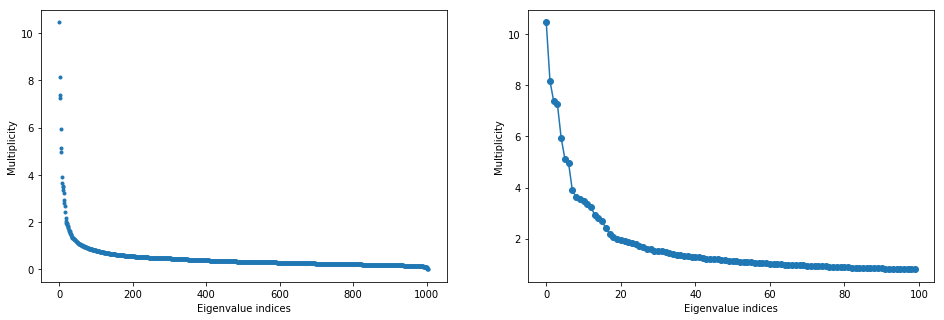

In [9]:
## Compute eigen-spectrum
xs = np.arange(CSE.n)
eigvals = CSE.get_sorted_eig(CSE.S)[0]
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(xs[:], eigvals[:], '.')
plt.xlabel('Eigenvalue indices')
plt.ylabel('Multiplicity')
plt.subplot(122)
plt.plot(xs[:100], eigvals[:100], '-o')
plt.xlabel('Eigenvalue indices')
plt.ylabel('Multiplicity')
plt.show()

In [10]:
## Determine a good cut-off value
p_opt = 50 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  50


Looking at the original and zoomed-in plots above, we set the cut-off value for eigenvectors. We informally look for the [elbow](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) in the graph, so that all eigenvalues except the most largest ones are discarded. Next section shows how efficiently the denoised version captures the information in the original matrix.

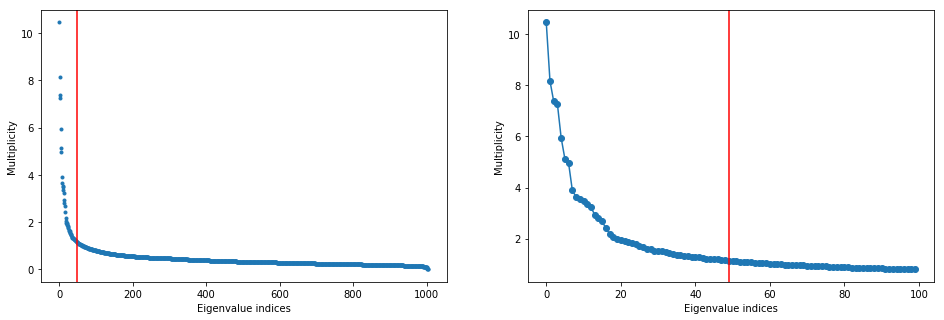

In [11]:
## Plot spectrum and indicate the cut-off value on the spectrum
xs = np.arange(CSE.n)
eigvals = CSE.get_sorted_eig(CSE.S)[0]
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(xs, eigvals, '.')
plt.axvline(x=p_opt-1, color='r')
plt.xlabel('Eigenvalue indices')
plt.ylabel('Multiplicity')
plt.subplot(122)
plt.plot(xs[:100], eigvals[:100], '-o')
plt.axvline(x=p_opt-1, color='r')
plt.xlabel('Eigenvalue indices')
plt.ylabel('Multiplicity')
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Perform K-MEANS algorithm on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. Plot the distance matrices for varying number of clusters K, both for the denoised ($p = p^*$ - from the previous step) and the original version as shown in figure 5 in [1]. To make the plots meaningful, sort the nodes according to the cluster belongings (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [12]:
def match_1to1(y_true, y_pred):
    '''
    Optimally 1-to-1 matches the predicted cluster to groundtruth. 
    '''
    C = confusion_matrix(y_true, y_pred)
    A = linear_assignment(-C.T)
    y_pred_hat = np.array([A[:,1][y_pred[I]] for I in ndi.ndindex(y_pred.shape)])
    return y_pred_hat

def match_Mto1(y_true, y_pred, k):
    '''
    Matches the predicted cluster to groundtruth ones greedily,
    matching is not necessarily 1-to-1. 
    '''
    y_pred_hat = y_pred.copy()
    for cid in range(k):
        pids = y_pred == cid
        best_matches = 0
        for gid in range(42):
            gids = y_true == gid
            matches = np.sum(np.logical_and(pids, gids).astype(int))
            if matches > best_matches:
                best_matches = matches
                y_pred_hat[pids] = gid
    return y_pred_hat
    
def groundtruth():
    '''
    Returns the groundtruth clustering of the data. 
    '''
    AFFILIATIONS = np.zeros((NUM_NODES, ))
    with open("email-Eu-core-department-labels.txt") as file:
        for line in file:
            pair = [int(x) for x in line.split()]
            AFFILIATIONS[pair[0]] = pair[1]
    return AFFILIATIONS
                    
def plot_D(d_perm, idsizes, title, vmin, vmax, sep=True):
    '''
    Plots the dissimilarity matrix. 
    '''
    cumids = np.cumsum(idsizes)-0.5
    plt.matshow(d_perm, fignum=False, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.tick_params(axis='both', which='major', length=10)
    plt.xticks(cumids, ['']*len(idsizes))
    plt.yticks(cumids, ['']*len(idsizes))
    if sep:
        lw = 0.7
        for pos in cumids:
            plt.axvline(x=pos, color='r', linewidth=lw)
            # plt.axhline(y=pos, color='r', linewidth=lw)
    plt.title(title, y=ypos)
    plt.colorbar(fraction=0.046, pad=0.04)

def indices_D(clusters):
    '''
    Sorts the indices so that the nodes belonging
    to same clusters are positioned subsequently. 
    '''
    permutes = []
    idsizes = []
    for j in range(k):
        ids = np.where(clusters==j)[0]
        idsizes.append(ids.size)
        permutes.append(ids)
    permutes = np.concatenate(permutes)
    return permutes, idsizes

def permute_D(d_mat, permutes):
    '''
    Permutes the dissimilarity matrix according to the given indices. 
    '''
    d_perm = d_mat.copy()
    d_perm = d_perm[permutes,:]
    d_perm = d_perm[:, permutes]
    return d_perm

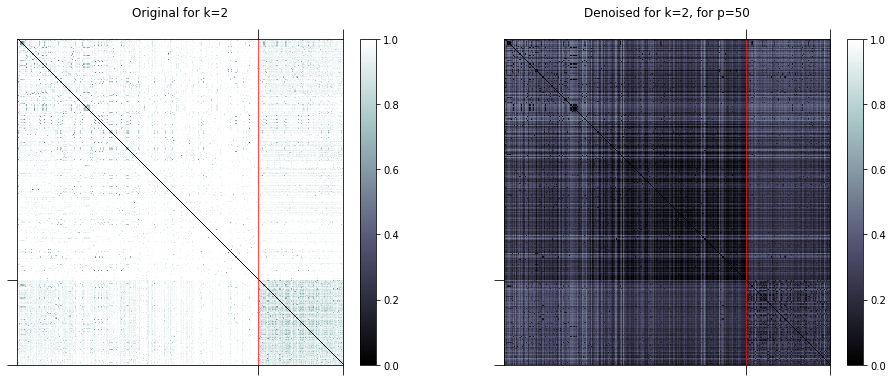

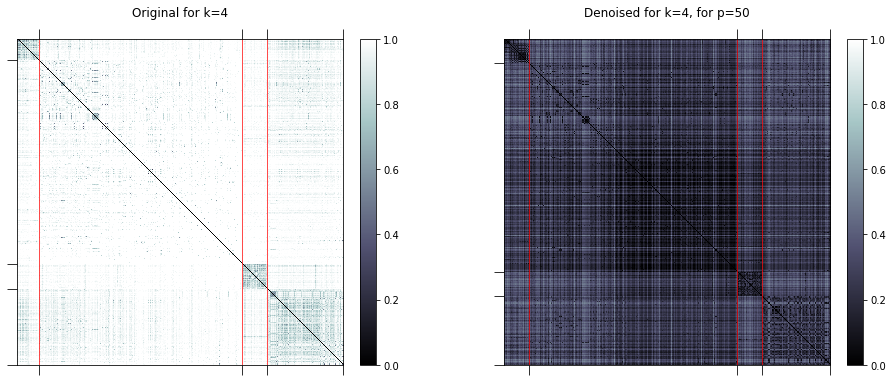

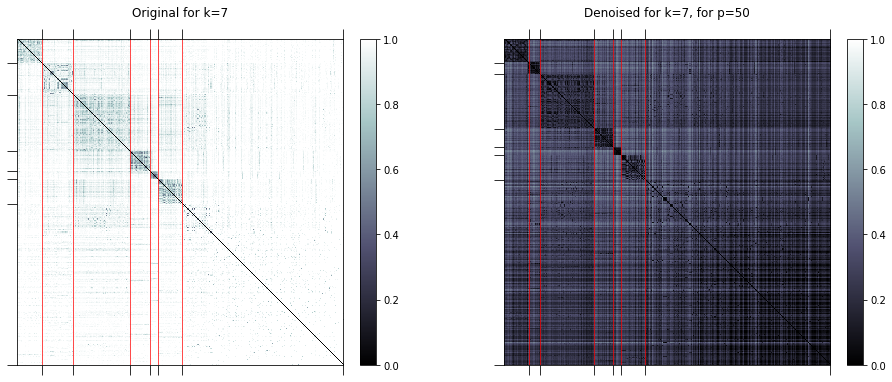

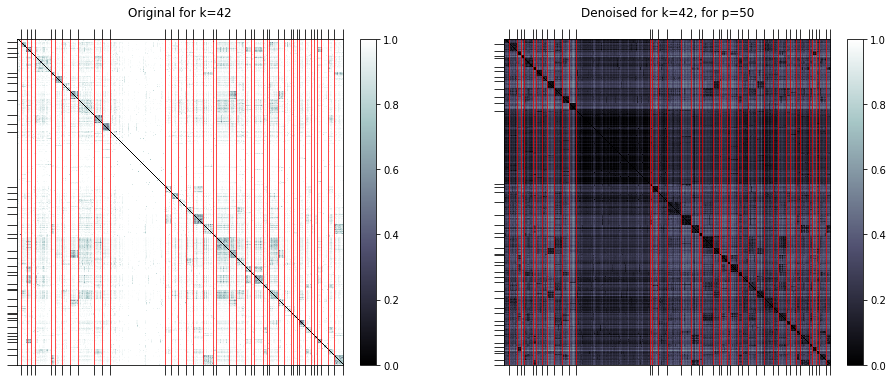

1 to 1 matching
Original accuracy: 0.4228855721393035
Denoised accuracy: 0.4208955223880597
Many to 1 matching
Original accuracy: 0.591044776119403
Denoised accuracy: 0.591044776119403


In [13]:
# Plotting variables
ypos = 1.05
cmap = plt.cm.bone

Xp_opt, D_popt = CSE.get_embedded_vectors(p_opt)
X_orig, D_orig = CSE.get_embedded_vectors(CSE.n)

for k in [2,4,7,42]:
    kmeans_orig = KMeans(n_clusters=k, random_state=0, n_init=45).fit(X_orig)
    kmeans_popt = KMeans(n_clusters=k, random_state=0, n_init=45).fit(Xp_opt)
    
    clusters_orig = kmeans_orig.predict(X_orig)
    clusters_popt = kmeans_popt.predict(Xp_opt)
    clusters_popt_ = match_1to1(clusters_orig, clusters_popt)

    permutes_popt, idsize_popt = indices_D(clusters_popt_)
    permutes_orig, idsize_orig = indices_D(clusters_orig)
    
    D_popt_ = permute_D(D_popt, permutes_popt)
    D_orig_ = permute_D(D_orig, permutes_orig)

    vmin = np.min(D_orig_)
    vmax = np.max(D_orig_)
    
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plot_D(D_orig_, idsize_orig, 'Original for k=' + str(k), vmin, vmax)
    plt.subplot(122)
    plot_D(D_popt_, idsize_popt, 'Denoised for k=' + str(k) + ', for p=' + str(p_opt), vmin, vmax)
    plt.show()

    if k == 42:
        print('1 to 1 matching')
        y_true = groundtruth()
        print('Original accuracy:', accuracy_score(y_true, match_1to1(y_true, clusters_orig)))
        print('Denoised accuracy:', accuracy_score(y_true, match_1to1(y_true, clusters_popt)))
    
    if k >= 42:
        print('Many to 1 matching')
        y_true = groundtruth()
        print('Original accuracy:', accuracy_score(y_true, match_Mto1(y_true, clusters_orig, k)))
        print('Denoised accuracy:', accuracy_score(y_true, match_Mto1(y_true, clusters_popt, k)))

We show the original and denoised dissimilarity matrices for different k values. Matrices are permuted acordingly so the cluster ordering is the same in both versions, to make it easier when comparing them. It is noticeable that these two versions are most of the time quite similar, confirming our choice of optimal p value. We additionally compare our results for $k=42$ to the groundtruth clustering as a sanity check.

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Now calculate the embeddings for p = 2, 3 and plot clusterings for a few values of K. Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Alternatively, you could use $p^*$ and then apply a dimensionality reduction technique to move to 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [14]:
## Get embeddings, run K-MEANS and generate plots
## project computed p-dimentional embeddings onto 2-dimensional space using PCA, LL, t-SNE or something else

In [9]:
def plot_embed(Xe, ks, d):
    '''
    Plots the provided embedding for the
    specified k values, either in 2D or 3D.
    '''
    pa = 1      # alpha
    ps = 5      # size
    pm = "."    # marker
    fs = (15,4) # figsize
    if d == 3 or len(ks) == 1:
        fs = (9,6)
    if len(ks) == 1 and d == 2:
        pm = 'o'
        
    fig = plt.figure(figsize=fs)
    
    for cid, k in enumerate(ks):
        if d == 2:
            ax = fig.add_subplot(1, len(ks), cid+1)
        if d == 3:
            ax = fig.add_subplot(1, len(ks), cid+1, projection='3d')
        # ax.set_title('k=' + str(k))
        km = KMeans(n_clusters=k, random_state=0, n_init=45).fit(Xp)
        cl = km.predict(Xp)
        for i in range(k):
            ids = np.where(cl == i)
            if d == 2:
                ax.scatter(Xe[ids,0], Xe[ids,1], marker=pm, s=ps, alpha=pa, label=str(i))
            if d == 3:
                ax.scatter(Xe[ids,0], Xe[ids,1],  Xe[ids,2], marker=pm, alpha=pa, label=str(i))
    plt.show();

Embeddings obtained from $p=2$, illustrated on various values of k.

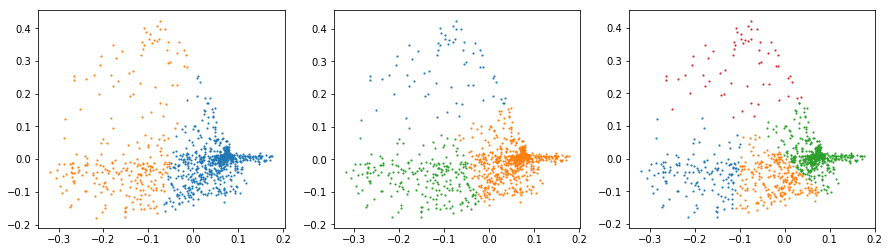

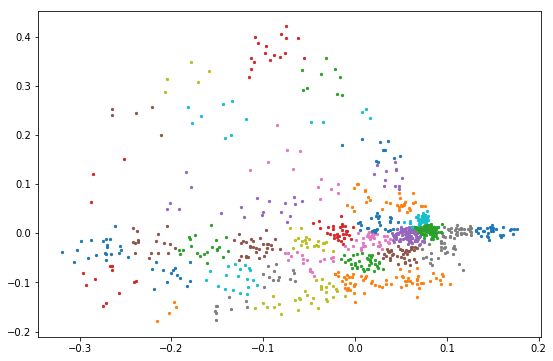

In [16]:
%matplotlib inline
Xp, Dp = CSE.get_embedded_vectors(2)
plot_embed(Xe=Xp, d=2, ks=[2,3,4])
plot_embed(Xe=Xp, d=2, ks=[42])

Embeddings obtained from $p=3$, illustrated on various values of k.

In [17]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

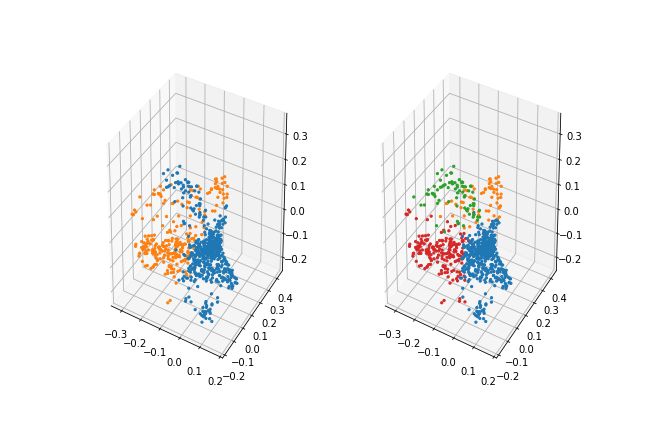

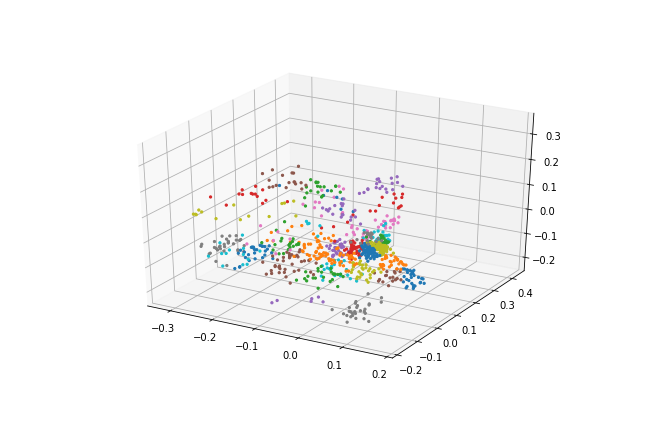

In [18]:
Xp, Dp = CSE.get_embedded_vectors(3)
plot_embed(Xe=Xp, d=3, ks=[2,4])
plot_embed(Xe=Xp, d=3, ks=[42])

Embeddings obtained from t-SNE on $p=p_{opt}$, illustrated on various values of k.

In [19]:
Xp, Dp = CSE.get_embedded_vectors(p_opt)

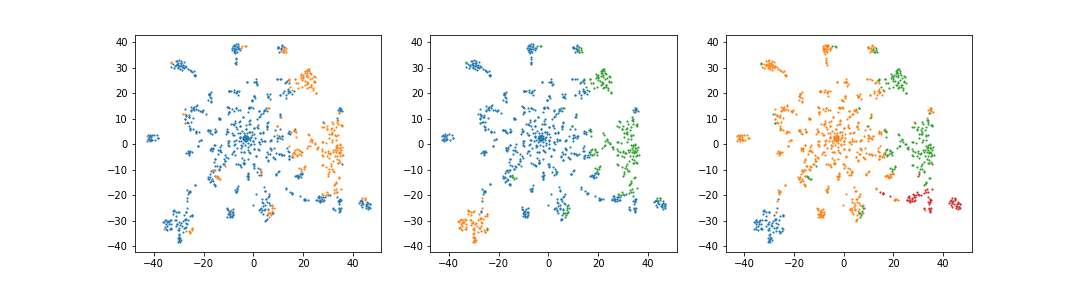

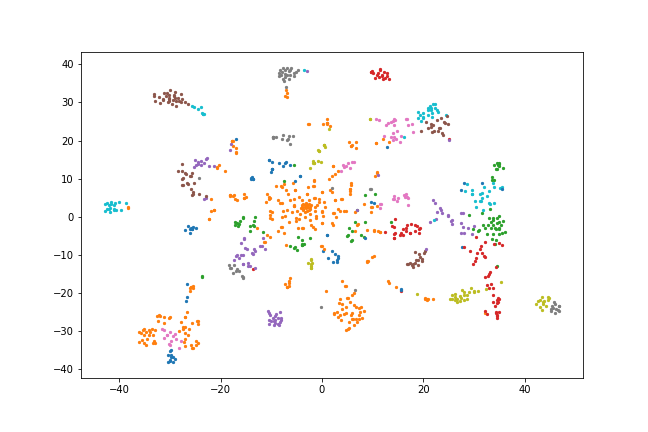

In [20]:
%matplotlib inline
d = 2
Xtsne = TSNE(n_components=d, random_state=tsne_rs).fit_transform(Xp)
plot_embed(Xe=Xtsne, d=d, ks=[2,3,4])
plot_embed(Xe=Xtsne, d=d, ks=[42])

In [21]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

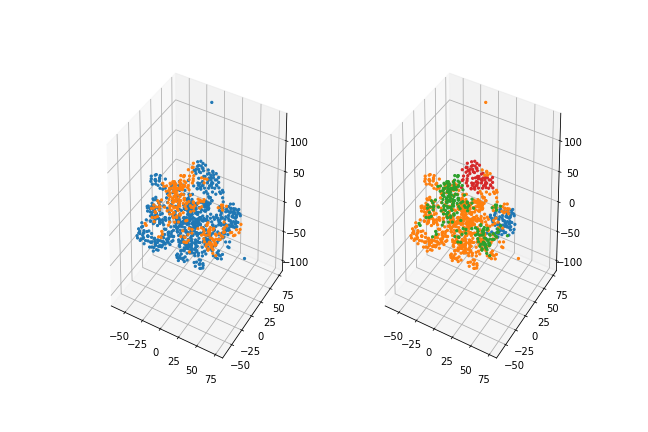

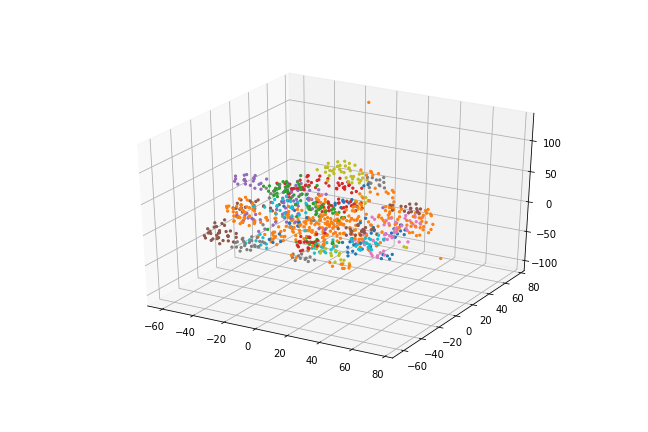

In [22]:
d = 3
Xtsne = TSNE(n_components=d, random_state=tsne_rs).fit_transform(Xp)
plot_embed(Xe=Xtsne, d=d, ks=[2,4])
plot_embed(Xe=Xtsne, d=d, ks=[42])

It is tricky to make it work with 3D interactive plots in jupyter. Code for the interactive versions are provided in the appendix. It may need restarting the notebook and skipping this section to run the interactive versions as intended.

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2].
</p>

In [23]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [24]:
## Here you can provide plots and calculations

In [25]:
def plot_groundtruth(Xe, y_true, y_pred, k):
    '''
    Plots the groundtruth and prediction clusterings
    on the provided embeddings.
    '''
    pa = 1       # alpha
    ps = 5       # size
    pm = 'o'     # marker
    fs = (20,8)   # figsize

    plt.figure(figsize=fs)
    
    plt.subplot(121)
    plt.title('Ground truth, k=' + str(k))
    for i in range(k):
        ids = np.where(y_true == i)
        plt.scatter(Xe[ids,0], Xe[ids,1], marker=pm, s=ps, alpha=pa, label=str(i))    
    plt.subplot(122)
    plt.title('Predictions, k=' + str(k))
    for i in range(k):
        ids = np.where(y_pred == i)
        plt.scatter(Xe[ids,0], Xe[ids,1], marker=pm, s=ps, alpha=pa, label=str(i))
    plt.show()

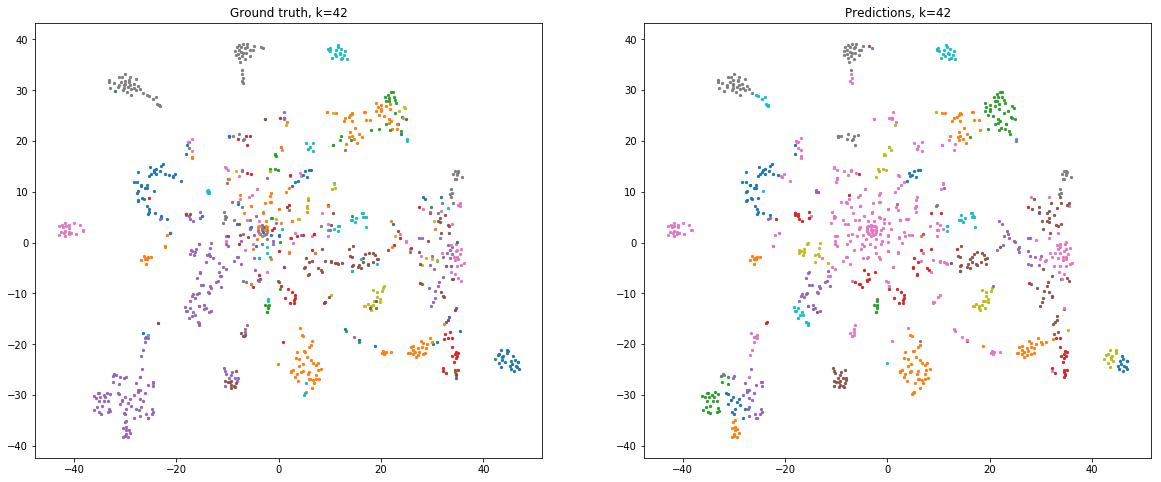

1-to-1 matching accuracy: 0.4208955223880597


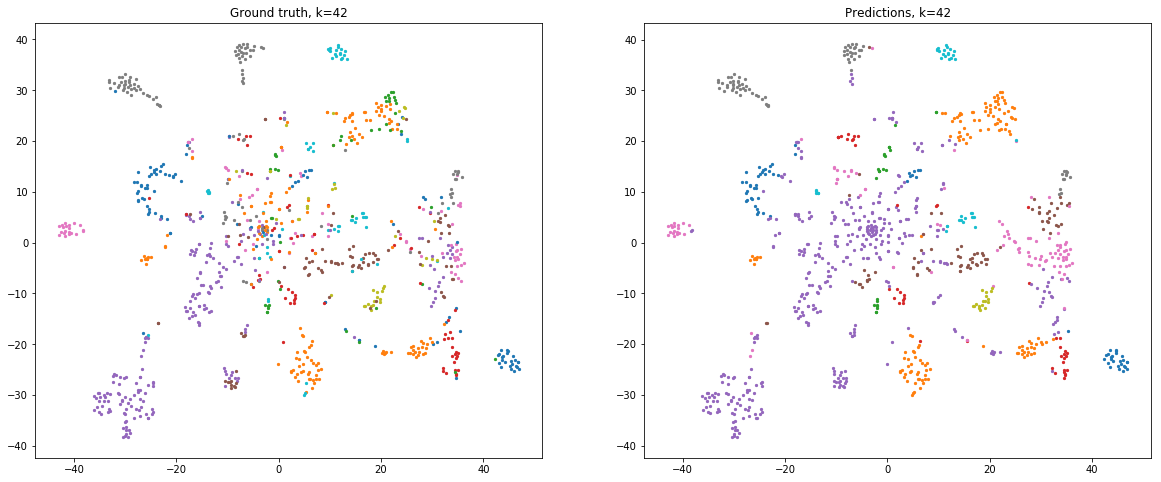

Many-to-1 matching accuracy: 0.591044776119403


In [26]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
k = len(np.unique(AFFILIATIONS))
p = p_opt
Xp, Dp = CSE.get_embedded_vectors(p)
Xtsne = TSNE(n_components=2, random_state=tsne_rs).fit_transform(Xp)
km = KMeans(n_clusters=k, random_state=0, n_init=45).fit(Xp)
cl = km.predict(Xp)
y_true = AFFILIATIONS

y_pred = match_1to1(y_true, cl)
plot_groundtruth(Xtsne, y_true, y_pred, k)
print('1-to-1 matching accuracy:', accuracy_score(y_true, y_pred))

y_pred_ = match_Mto1(y_true, cl, k)
plot_groundtruth(Xtsne, y_true, y_pred_, k)
print('Many-to-1 matching accuracy:', accuracy_score(y_true, y_pred_))

We evaluate our clustering results in two ways. First is 1-to-1 matching, where each of the clusters in groudtruth should have one and only one match in predicted clusters. This is the classical setting. We also report a many-to-1 cluster matching where we allow multiple predicted clusters to be matched to one groundtruth cluster, which may lead some of the actual clusters to be non-matched. Plot above shows the 1-to-1 results and the one below shows that of the many-to-1 setting.  
Looking at both of the results illustrated by t-SNE, we can see that numerous different clusters form a data cloud of considerable size, for the groundtruth labels. It is those data points which make it hard to cluster in either scenario. We interpret this as a shortcoming of our proposed distance metric, which seems to be unable to distinguish data points belonging to multiple clusters from one another. Interestingly enough, CSE seems to have transformed the data successfully that we can see emerging clusters that almost perfectly correspond to groundtruth ones. It is visibly more pleasing in many-to-1 setting, as assigning multiple actual clusters to one big jumble in predictions does not effect the assignments of the other clusters. In other words, cluster assignments are dependent one each other in the 1-to-1 scenario, which leads to poorer results because of the non-distinguishable clusters.  
We conclude that CSE works fine on its own, but its capabilities are being limited by the dissimilarity measure used on the graph. When the dissimilarity is not very informative, the clustering results are even exacerbated by the k-means as the embedding does not reflect the "real-world" pairwise distances, so to speak.

## Appendix

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
reload(plt)
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


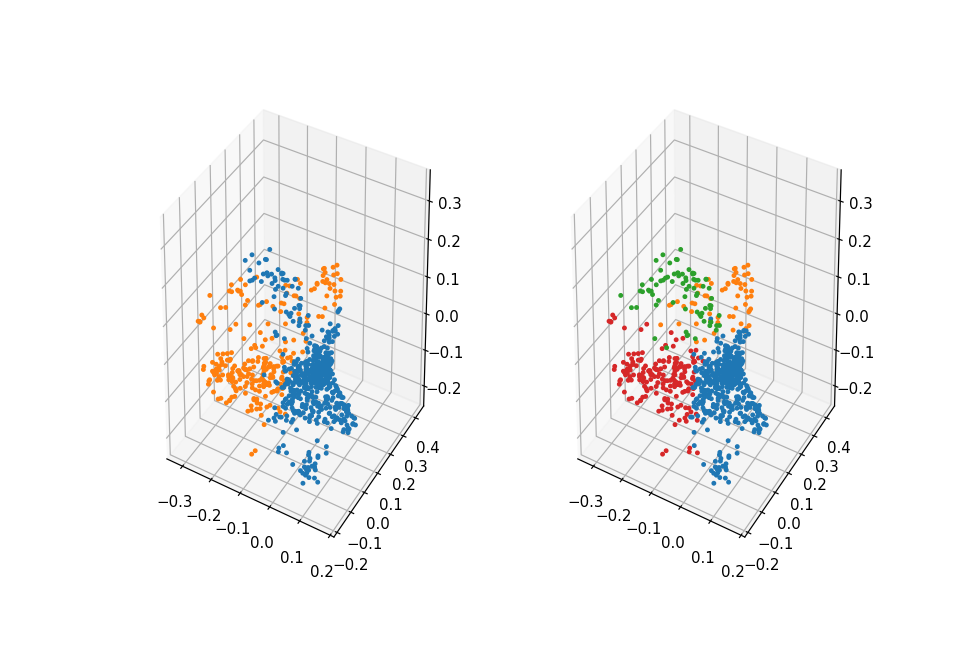

<IPython.core.display.Javascript object>


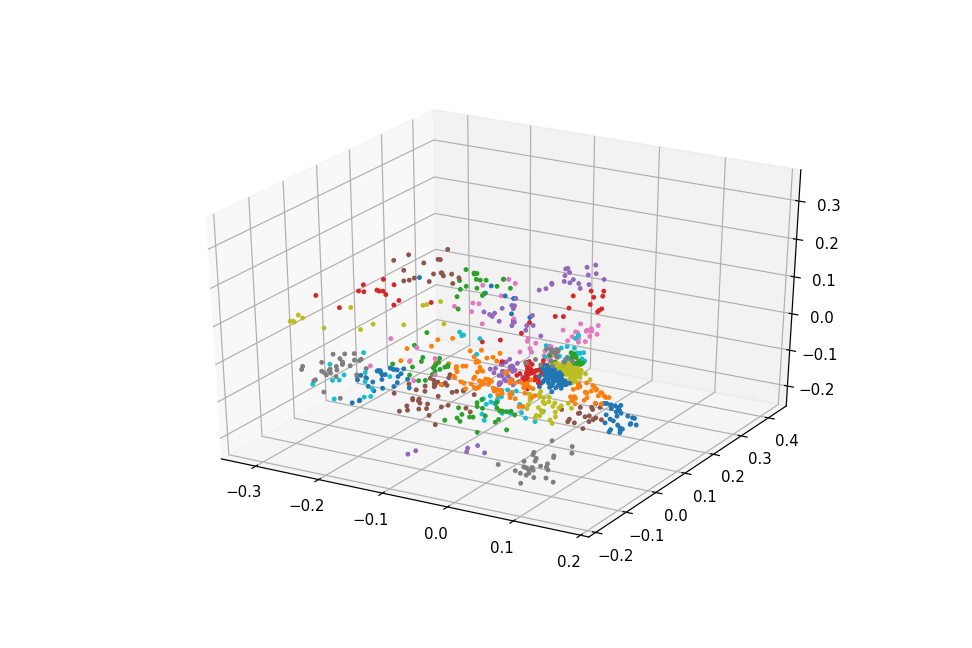

In [11]:
Xp, Dp = CSE.get_embedded_vectors(3)
plot_embed(Xe=Xp, d=3, ks=[2,4])
plot_embed(Xe=Xp, d=3, ks=[42])

<IPython.core.display.Javascript object>


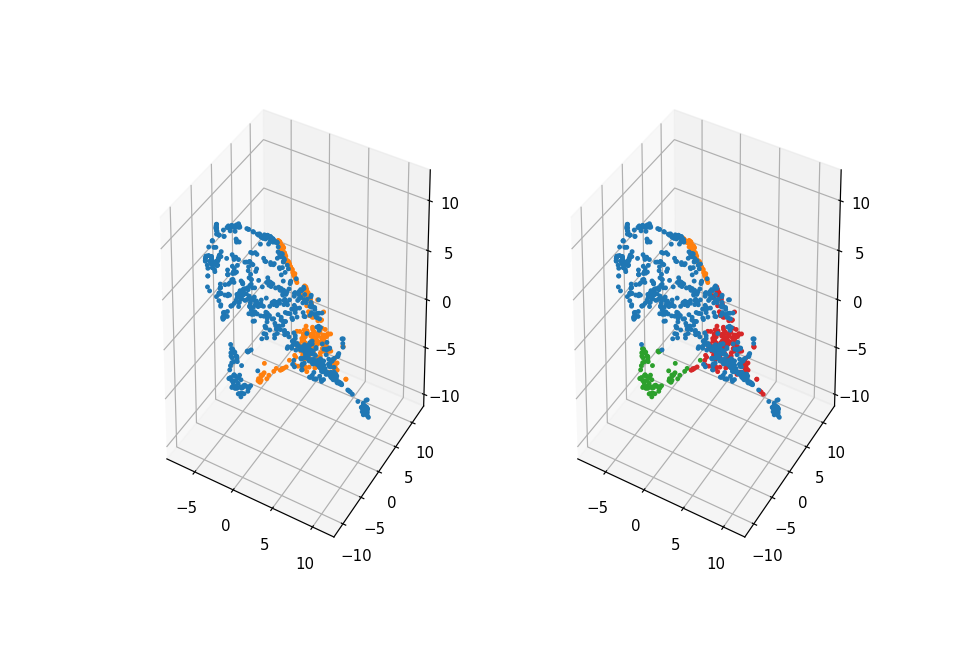

<IPython.core.display.Javascript object>


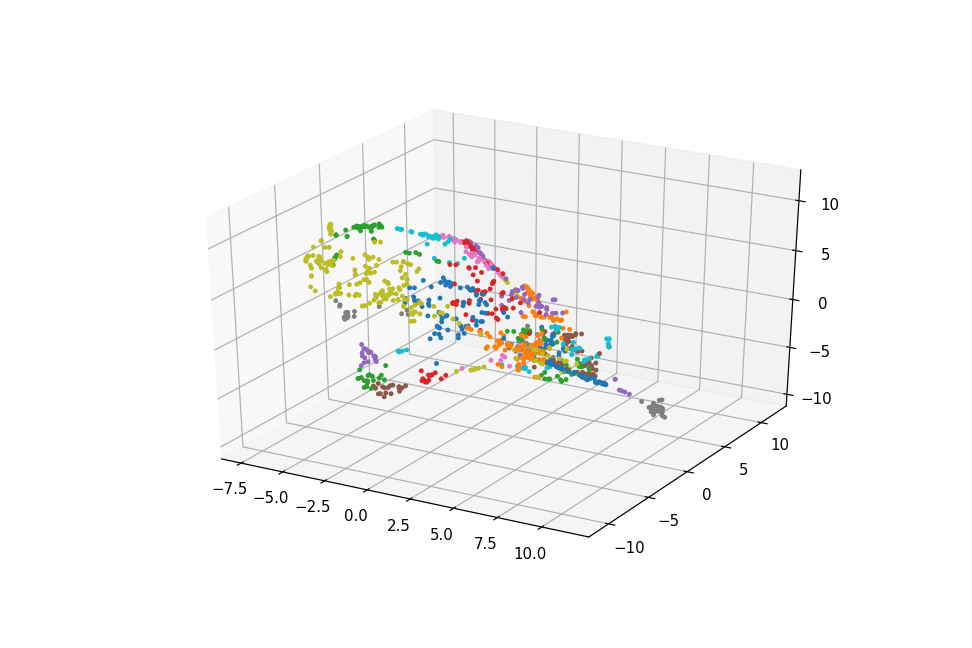

In [12]:
d = 3
Xtsne = TSNE(n_components=d, random_state=tsne_rs).fit_transform(Xp)
plot_embed(Xe=Xtsne, d=d, ks=[2,4])
plot_embed(Xe=Xtsne, d=d, ks=[42])

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.